In [1]:
#Generate the relevant time series plots:
import string
import os
import sys
import datetime as dtte
import numpy as np
import numpy.linalg as LA
import collections
import pickle
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
%matplotlib inline

In [2]:
DF = pd.read_csv('15TopicsTOTAL.csv')

In [3]:
start = dtte.datetime.strptime("2 Apr 07", "%d %b %y")
daterange = pd.date_range(start, periods=3209,freq='D')

In [4]:
Topic0Scores = DF['Topic 0']
Topic0Scores.index = pd.Index(daterange)

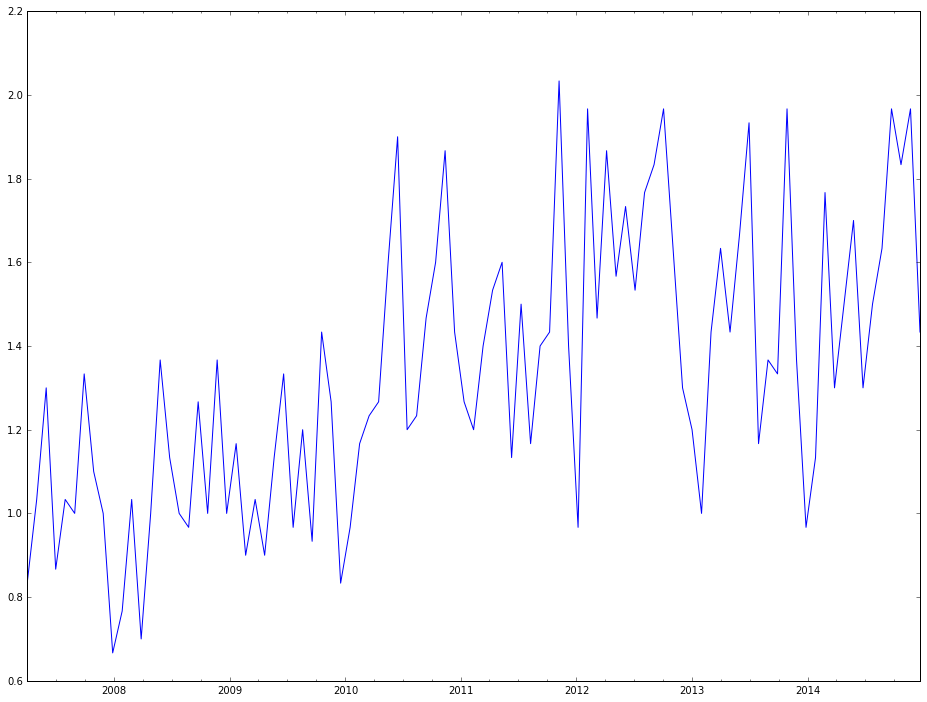

In [5]:
Topic0byMonth = Topic0Scores.resample('30D')
Topic0byMonth[:'2014-12-31'].plot(figsize=(16, 12))
ts = Topic0byMonth

In [6]:
#Is this more or less stationary?
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

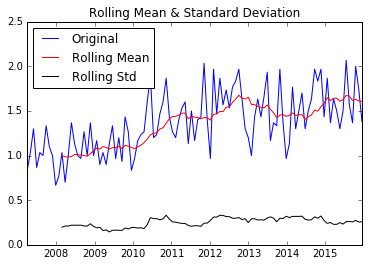

Results of Dickey-Fuller Test:
Test Statistic                  -2.448807
p-value                          0.128432
#Lags Used                       3.000000
Number of Observations Used    103.000000
Critical Value (10%)            -2.581971
Critical Value (5%)             -2.890037
Critical Value (1%)             -3.495493
dtype: float64


In [7]:
#Apply test to our time series:
test_stationarity(Topic0byMonth)

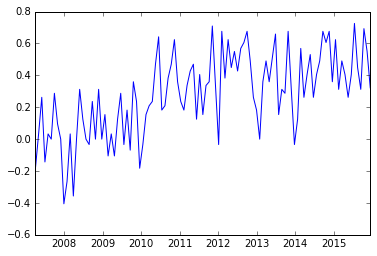

In [8]:
#Nope this is not stationary! This is why the fit was so weird...fuck, means, I have to redo this... We're close though, 
#The test statistic is almost within the 5 percent critical value...so just little transformation should take care of this.
#Take a log transformation
ts_log = np.log(Topic0byMonth)
plt.plot(ts_log)

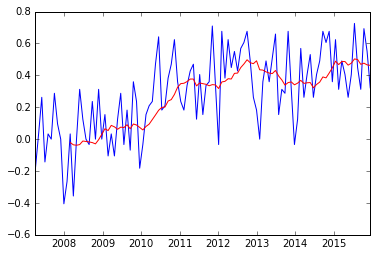

In [9]:
#Now compute the moving average
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [10]:
#difference this from the log-ed time series:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

2007-04-02         NaN
2007-05-02         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-07-31         NaN
2007-08-30         NaN
2007-09-29         NaN
2007-10-29         NaN
2007-11-28         NaN
2007-12-28         NaN
2008-01-27         NaN
2008-02-26    0.053862
Freq: 30D, Name: Topic 0, dtype: float64

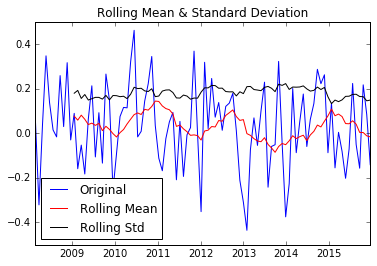

Results of Dickey-Fuller Test:
Test Statistic                -8.269285e+00
p-value                        4.842245e-13
#Lags Used                     0.000000e+00
Number of Observations Used    9.500000e+01
Critical Value (10%)          -2.583275e+00
Critical Value (5%)           -2.892480e+00
Critical Value (1%)           -3.501137e+00
dtype: float64


In [11]:
#Drop the NANs and check stationarity:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [12]:
#Good.
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [22]:
lag_acf = acf(ts_log_moving_avg_diff, nlags=15)
lag_pacf = pacf(ts_log_moving_avg_diff, nlags=15, method='ols')

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 <a list of 10 Text yticklabel objects>)

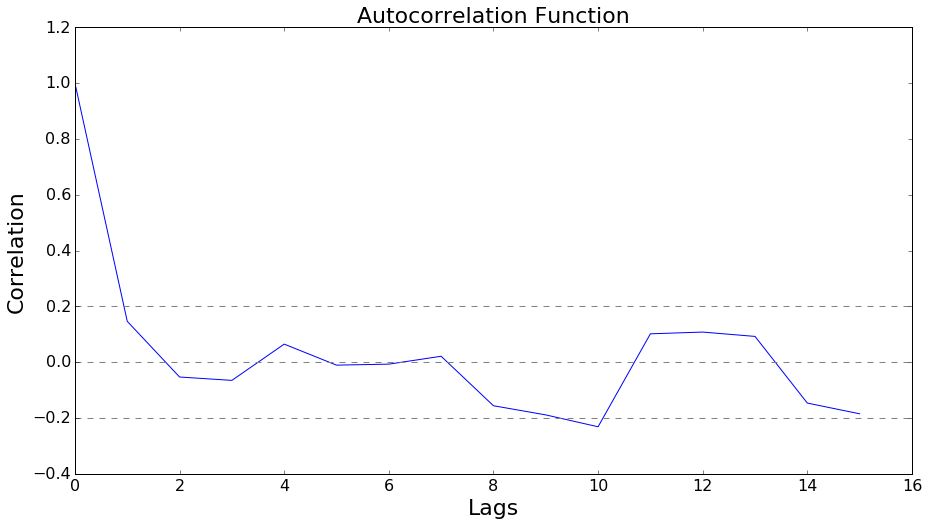

In [27]:
#Plot ACF: 
#plt.subplot(121) 
plt.figure(figsize=(15,8))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function',fontsize=22)
plt.ylabel('Correlation',fontsize=22)
plt.xlabel('Lags',fontsize=22)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 <a list of 10 Text yticklabel objects>)

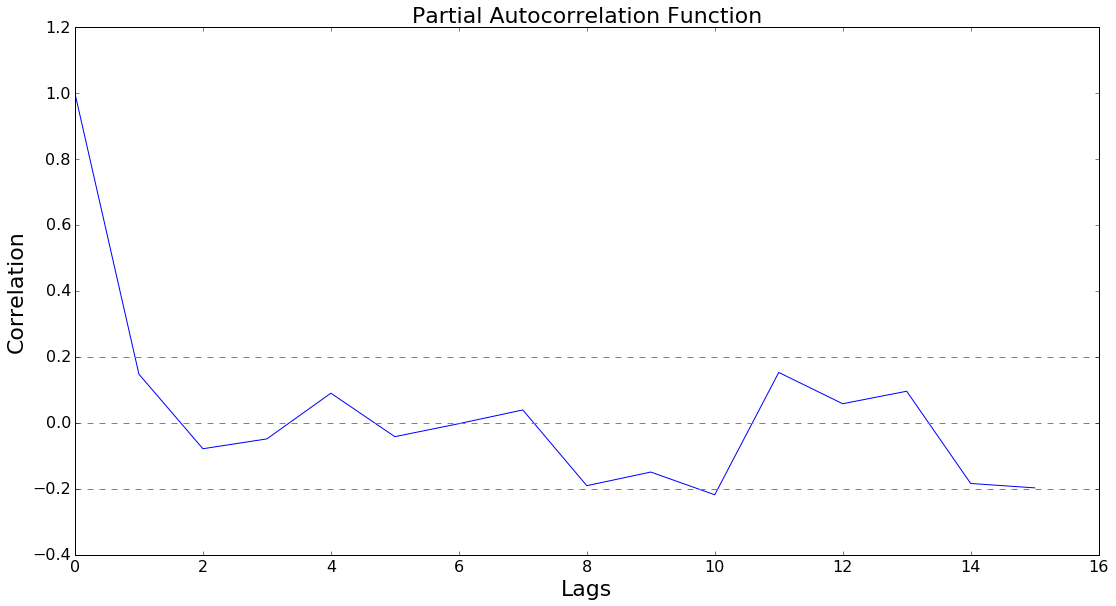

In [28]:
#Plot PACF:
#plt.subplot(122)
plt.figure(figsize=(15,8))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.title('Partial Autocorrelation Function',fontsize=22)
plt.ylabel('Correlation',fontsize=22)
plt.xlabel('Lags',fontsize=22)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)

In [39]:
#Estimate: p = The lag value where the PACF chart crosses the upper confidence interval for the first time.
#q = The lag value where the ACF chart crosses the upper confidence interval for the first time.
#so p = 1 or 2
#q = 1 or 2.  Run grid search on these values to see what to use to minimize AIC.  
def objfunc(order):
    from statsmodels.tsa.arima_model import ARMA
    try:
        #fit = ARMA(DFTopic1a['First Difference'].ix['2007-04-05':], order).fit()
        fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,order).fit()
        #fit = sm.tsa.ARIMA(ts_log,order).fit()
        print(fit.aic)
        print(order)
        return fit.aic
    except:
        print('No good!')
        print(order)

from scipy.optimize import brute
grid = (slice(0,3,1), slice(0, 3, 1), slice(0,3,1))
brute(objfunc, grid, finish=None)

-51.3884128362
[0 0 0]
-51.3884128362
[0 0 0]
-51.7248192473
[0 0 1]
-49.8002239848
[0 0 2]
0.445124446661
[0 1 0]
-44.1694326157
[0 1 1]
-44.612078738
[0 1 2]
95.4379335001
[0 2 0]
8.01880436146
[0 2 1]
No good!
[0 2 2]
-51.4702211497
[1 0 0]
-49.7597633415
[1 0 1]
No good!
[1 0 2]
-12.4760717064
[1 1 0]
No good!
[1 1 1]
-44.1202141154
[1 1 2]
56.5750012771
[1 2 0]
No good!
[1 2 1]
No good!
[1 2 2]
-50.0633785302
[2 0 0]
-48.1364334832
[2 0 1]
-52.0730110209
[2 0 2]
-19.1313197098
[2 1 0]
-42.9517241394
[2 1 1]
-41.0353355491
[2 1 2]
41.3263640093
[2 2 0]
No good!
[2 2 1]
No good!
[2 2 2]


/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


array([ 0.,  2.,  2.])

In [40]:
#Double check convergence (2,0,2) (1,0,1) (2,1,2)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(0,0,2)).fit()
fit.aic

-49.80022398479707

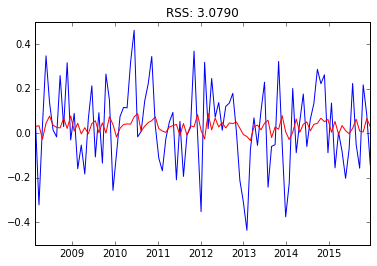

In [61]:
model = sm.tsa.ARIMA(ts_log_moving_avg_diff, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_moving_avg_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
ParRSS = results_ARIMA.fittedvalues-ts_log_moving_avg_diff
ParRSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum((ParRSS)**2))

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/tsa/arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


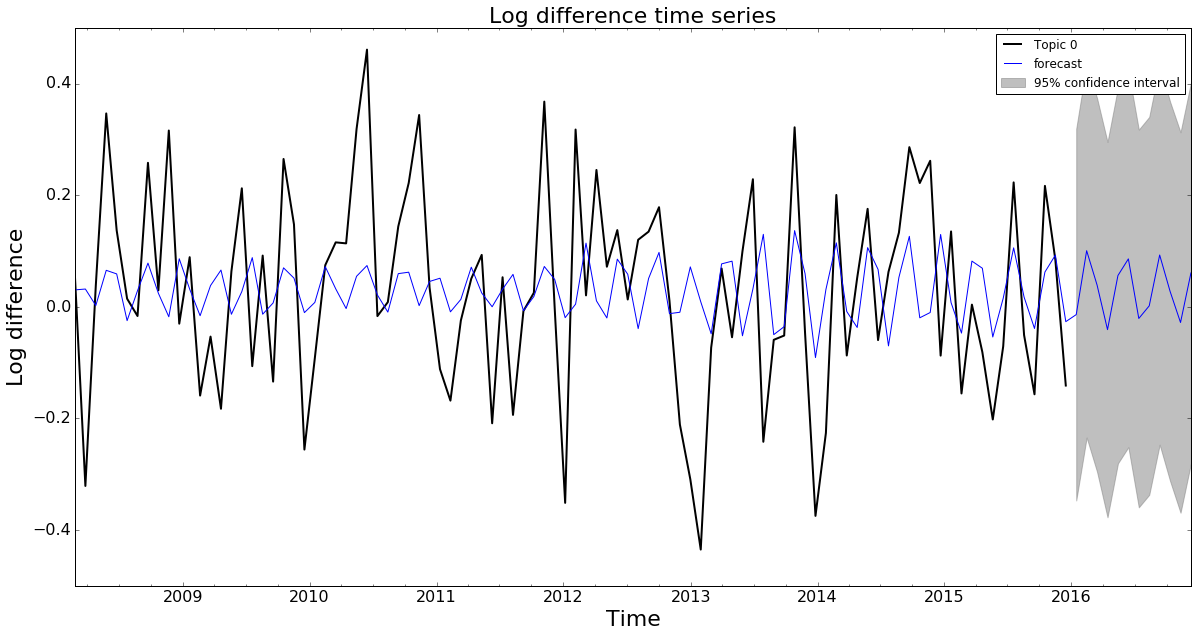

In [76]:
#Well not a great fit, but it's honest at least...can we transform back to original data and make predictions?
#Make predictions first to make sure it looks ok... 2007-05-02 2013-12-26
with mpl.rc_context():
    mpl.rc('axes', color_cycle=['#0000FF', '#FF6600'])
    fig, ax = plt.subplots(figsize=(20, 10))
    ax = ts_log_moving_avg_diff.plot(linewidth=2.0,ax=ax,color='black')
    fig = sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,2)).fit(disp=-1).plot_predict('2008-02-26', '2016', ax=ax,plot_insample=False)
    plt.xticks(fontsize=16)  
    plt.yticks(fontsize=16)
    plt.title("Log difference time series",fontsize=22)
    plt.xlabel("Time",fontsize=22)
    plt.ylabel("Log difference",fontsize=22)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


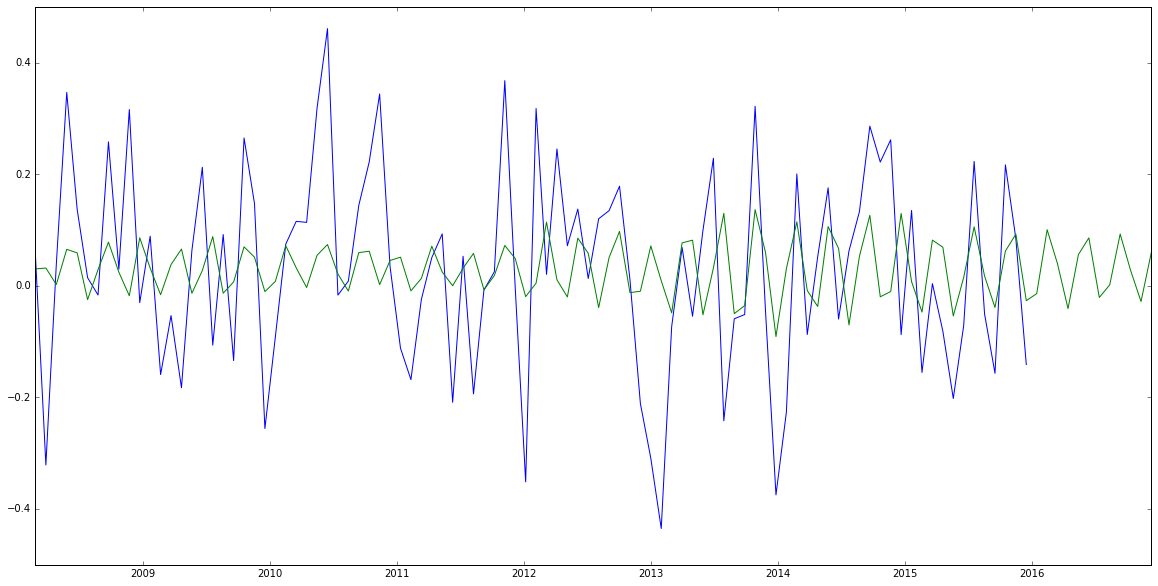

In [77]:
plt.subplots(figsize=(20, 10))
plt.plot(ts_log_moving_avg_diff)
plt.plot(sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,2)).fit(disp=-1).predict('2008-02-26', '2016'))

2008-02-26    0.030282
2008-03-27    0.031849
2008-04-26    0.002292
2008-05-26    0.065381
2008-06-25    0.058945
Freq: 30D, dtype: float64


/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


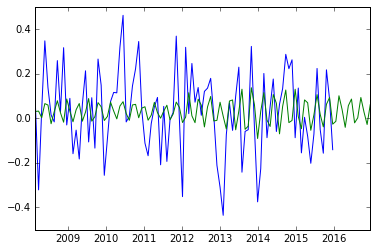

In [78]:
predictions_ARIMA_diff = pd.Series(sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,2)).fit(disp=-1).predict('2008-02-26', '2016'), copy=True)
print(predictions_ARIMA_diff.head())
plt.plot(ts_log_moving_avg_diff)
plt.plot(predictions_ARIMA_diff)

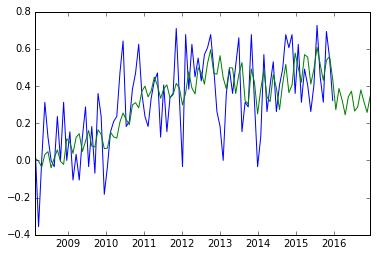

In [79]:
SplitPredict = predictions_ARIMA_diff['2016-01-15':]
InRangePredict = predictions_ARIMA_diff[:'2015-12-16']
InRangeTrans = InRangePredict + moving_avg
MovingToAdd = moving_avg.mean()
AverageDF = pd.Series([MovingToAdd for x in range(len(SplitPredict.index))], index=SplitPredict.index)
PredictedNew = SplitPredict + AverageDF
FullPredict = pd.Series.append(InRangeTrans,PredictedNew)
compare = ts_log_moving_avg_diff + moving_avg
plt.plot(compare)
plt.plot(FullPredict)

In [80]:
predictions_ARIMA

2007-04-02         NaN
2007-05-02         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-07-31         NaN
2007-08-30         NaN
2007-09-29         NaN
2007-10-29         NaN
2007-11-28         NaN
2007-12-28         NaN
2008-01-27         NaN
2008-02-26    1.009253
2008-03-27    0.996255
2008-04-26    0.964600
2008-05-26    1.031707
2008-06-25    1.048262
2008-07-25    0.961422
2008-08-24    1.011652
2008-09-23    1.058322
2008-10-23    0.994697
2008-11-22    0.978771
2008-12-22    1.123340
2009-01-21    1.101757
2009-02-20    1.038442
2009-03-22    1.132295
2009-04-21    1.153999
2009-05-21    1.049569
2009-06-20    1.108114
2009-07-20    1.174220
2009-08-19    1.080295
                ...   
2014-07-24    1.313747
2014-08-23    1.507638
2014-09-22    1.676127
2014-10-22    1.439972
2014-11-21    1.498476
2014-12-21    1.780970
2015-01-20    1.643162
2015-02-19    1.522851
2015-03-21    1.765837
2015-04-20    1.743328
2015-05-20    1.507210
2015-06-19    1.634987
2015-07-19 

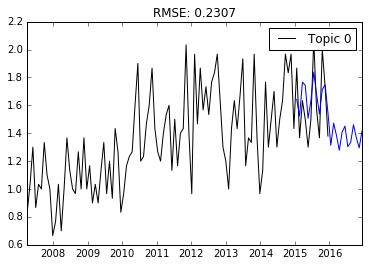

In [81]:
predictions_ARIMA = np.exp(FullPredict)
plt.plot(ts,color='black')
plt.plot(predictions_ARIMA['2015-01-20':],color='blue')
RMSEeval = predictions_ARIMA-ts
RMSEeval.dropna(inplace=True)
plt.title('RMSE: %.4f'% np.sqrt(sum((RMSEeval)**2)/len(ts)))
plt.legend()

In [82]:
ts_log_moving_avg_diff

2008-02-26    0.053862
2008-03-27   -0.321073
2008-04-26    0.038334
2008-05-26    0.346541
2008-06-25    0.136974
2008-07-25    0.014544
2008-08-24   -0.016533
2008-09-23    0.258032
2008-10-23    0.029586
2008-11-22    0.315929
2008-12-22   -0.030234
2009-01-21    0.088929
2009-02-20   -0.159070
2009-03-22   -0.053375
2009-04-21   -0.182745
2009-05-21    0.063379
2009-06-20    0.212355
2009-07-20   -0.106404
2009-08-19    0.091801
2009-09-18   -0.134065
2009-10-18    0.264930
2009-11-17    0.147649
2009-12-17   -0.255868
2010-01-16   -0.091777
2010-02-15    0.074649
2010-03-17    0.115475
2010-04-16    0.113664
2010-05-16    0.318542
2010-06-15    0.460878
2010-07-15   -0.016673
                ...   
2013-07-29   -0.241902
2013-08-28   -0.059198
2013-09-27   -0.051503
2013-10-27    0.321679
2013-11-26   -0.046454
2013-12-26   -0.374712
2014-01-25   -0.226077
2014-02-24    0.200430
2014-03-26   -0.087279
2014-04-25    0.052034
2014-05-25    0.175546
2014-06-24   -0.059644
2014-07-24 

In [83]:
TestConf = sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,2)).fit(disp=-1)
lowerInts = []
upperInts = []
for nums in TestConf.forecast(12)[2]:
    lowerInts.append(nums[0])
    upperInts.append(nums[1])

In [84]:
upperInts

[0.3190625944066634,
 0.43532809923811916,
 0.3737221596209237,
 0.29538628939990952,
 0.3927569739425581,
 0.42333422086585021,
 0.31754695246021064,
 0.34029763021124981,
 0.43267862485705166,
 0.3675531728792113,
 0.31273115678696672,
 0.40203979693820696]

In [85]:
#lowerInt = pd.Series([x[0] for x in range(len(SplitPredict.index))], index=SplitPredict.index)
lowerIntPD_orig = pd.Series(lowerInts,index=SplitPredict.index)
upperIntPD_orig = pd.Series(upperInts,index=SplitPredict.index)

In [86]:
lowerIntPD_avg = lowerIntPD_orig + AverageDF
upperIntPD_avg = upperIntPD_orig + AverageDF

In [87]:
FullLowerInt = np.exp(lowerIntPD_avg)
FullUpperInt = np.exp(upperIntPD_avg)

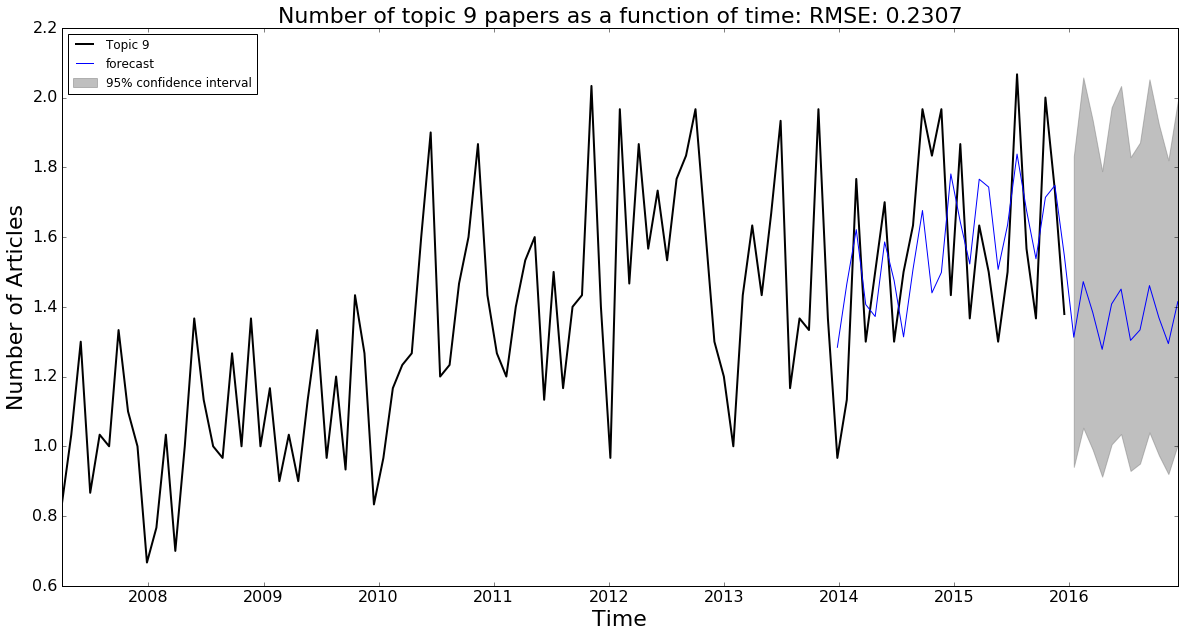

In [88]:
predictions_ARIMA = np.exp(FullPredict)
fig,ax= plt.subplots(figsize=(20, 10))
fig = plt.plot(ts,linewidth=2.0,color='black')
ax = plt.plot(predictions_ARIMA['2013-12-26':],color='blue')
plt.fill_between(FullLowerInt.index,FullLowerInt.values,FullUpperInt.values,color='grey',alpha=0.5)
RMSEeval = predictions_ARIMA-ts
RMSEeval.dropna(inplace=True)
plt.title('Number of topic 9 papers as a function of time: RMSE: %.4f'% np.sqrt(sum((RMSEeval)**2)/len(ts)),fontsize=22)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)
#plt.title("Number of papers as a function of time",fontsize=22)
plt.xlabel("Time",fontsize=22)
plt.ylabel("Number of Articles",fontsize=22)
plt.legend(['Topic 9','forecast','95% confidence interval'],loc='best')